# Bike Sharing Exploration
## by Meisam Ashraf

## Preliminary Wrangling

This data set includes information about individual rides made in a bike-sharing system covering the greater San Francisco Bay area. 

The original data are available <a href="https://s3.amazonaws.com/baywheels-data/index.html"> here</a>, under the <a href="https://baywheels-assets.s3.amazonaws.com/data-license-agreement.html">Bay Wheels License Agreement</a>. 

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

import os
import random
import math
from datetime import datetime as dt
import time
import calendar

%matplotlib inline

This dataset requires some data wrangling in order to make it tidy for analysis. There are multiple cities covered by the linked system, and multiple data files need to be joined together for a full year’s coverage.

At the time of writing this report, there are 26 csv files in the data set covering four years:

- **2017:** one csv file covering from 2017-06-28 to 2017-12-31
- **2018:** twelve csv files each covering an individual month of the year 2018
- **2019:** twelve csv files each covering an individual month of the year 2019
- **2020:** one csv file covering the first month of 2020

I saved the data in the workspace directory <i>'./data/csv/'</i>.

In [2]:
# store the csv file names into csvs variable
path_to_csv_files = 'data/csv/';
csvs = [
        '2017-fordgobike-tripdata.csv'  ,
        '201801-fordgobike-tripdata.csv',
        '201802-fordgobike-tripdata.csv',
        '201803-fordgobike-tripdata.csv',
        '201804-fordgobike-tripdata.csv',
        '201805-fordgobike-tripdata.csv',
        '201806-fordgobike-tripdata.csv',
        '201807-fordgobike-tripdata.csv',
        '201808-fordgobike-tripdata.csv',
        '201809-fordgobike-tripdata.csv',
        '201810-fordgobike-tripdata.csv',
        '201811-fordgobike-tripdata.csv',
        '201812-fordgobike-tripdata.csv',
        '201901-fordgobike-tripdata.csv',
        '201902-fordgobike-tripdata.csv',
        '201903-fordgobike-tripdata.csv',
        '201904-fordgobike-tripdata.csv',
        '201905-baywheels-tripdata.csv' ,
        '201906-baywheels-tripdata.csv' ,
        '201907-baywheels-tripdata.csv' ,
        '201908-baywheels-tripdata.csv' ,
        '201909-baywheels-tripdata.csv' ,
        '201910-baywheels-tripdata.csv' ,
        '201911-baywheels-tripdata.csv' ,
        '201912-baywheels-tripdata.csv' ,
        '202001-baywheels-tripdata.csv' ,
       ]

I load the csv files in a loop, save the data column types and number of rows for each file, and extract only 2000 rows (or if the file has less number of rows, all rows) and append it to one place.

Each trip is anonymized and is provided in multiple columns of information. I included those columns that are shared for all csv files:

- **bike_id:** Bike ID
- **duration_sec:** Trip Duration (seconds)
- **start_time:** Start Time and Date
- **end_time:** End Time and Date
- **start_station_id:** Start Station ID
- **start_station_name:** Start Station Name
- **start_station_latitude:** Start Station Latitude
- **start_station_longitude:** Start Station Longitude
- **end_station_id:** End Station ID
- **end_station_name:** End Station Name
- **end_station_latitude:** End Station Latitude
- **start_station_longitude:** End Station Longitude
- **user_type:** User Type (Subscriber or Customer – “Subscriber” = Member or “Customer” = Casual)

In [3]:
# The considered shared columns in all csv files 
shared_columns = [
                  'bike_id', 
                  'duration_sec', 
                  'start_time', 
                  'end_time', 
                  'start_station_id', 
                  'start_station_latitude', 
                  'start_station_longitude',
                  'start_station_name', 
                  'end_station_id', 
                  'end_station_latitude', 
                  'end_station_longitude',
                  'end_station_name', 
                  'user_type',
                 ]

In [4]:
# Fix the seed for reproducibility
random.seed(255)

# Initialize an empty dataframe for data to be considered for the 
# start of the study
df = pd.DataFrame()

# Loop over the csv file names, 
for csv in csvs:
    # Number of points to be extracted
    if '2017' in csv: # for file 2017 covers 6 months
        nr = 20000*6;
    else:
        nr = 20000;
    
    df_full = pd.read_csv(path_to_csv_files + csv);             # load full csv data, 
    num_samples = min(nr, df_full.shape[0]);                 # set the number of rows to be considered
    df_sampled = df_full[shared_columns].sample(num_samples);   # extract samples and 
    df = df.append(df_sampled, ignore_index=True);              # append to df

/home/ma/anaconda3/envs/dal/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3062: DtypeWarning: Columns (14) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
/home/ma/anaconda3/envs/dal/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3062: DtypeWarning: Columns (13,14) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


### Duration
Firtsly, I convert the duration_sec to duration_min (round off as integer)

In [7]:
# Add the new column
if not 'duration_min' in df:
    idx, column, value = 1, 'duration_min', df.duration_sec.astype('float')/60
    df.insert(loc=idx, column=column, value=value)
    df.duration_min = df.duration_min.astype('int')

# Remove the old column
if 'duration_sec' in df:
    df.drop('duration_sec',axis=1, inplace=True)

### Cleaning
I remove the id columns (except the bike id, which is to be changed to str)

In [8]:
# Change the bike id from int to str
df.bike_id = df.bike_id.astype("str")

# Drop the staion id columns (name columns are enough)
if 'start_station_id' in df:
    df.drop('start_station_id', axis=1, inplace=True)
if 'end_station_id' in df:
    df.drop('end_station_id', axis=1, inplace=True)

### Date-Time
Here, I extract hour, day of week, month number and the year from start_datetime:<br>
- extract timestamp, hour, day of week, month number and the year from start_datetime<br>
- remove star_datetime and end_datetime<br>

In [9]:
# Remove the end_time column 
# (we don't need it: start and duration is enough!)
if 'end_time' in df:
    df.drop('end_time', axis=1, inplace=True)

# Some date-time values come with second fraction ('%Y-%m-%d %H:%M:%S.%f')
# Make sure all are '%Y-%m-%d %H:%M:%S'
df.start_time = [t[:19] for t in df.start_time]

# A funtion that validates all date/time entries follow
# '%Y-%m-%d %H:%M:%S' format
def valid_datetime(date_string):
    date_format = '%Y-%m-%d %H:%M:%S'    
    try:
      date_obj = dt.strptime(date_string, date_format)
      return True;
    except ValueError:
      print(date_string)
      return False;

In [10]:
# Check the entries for validation. Should return True.
all([valid_datetime(start_time) for start_time in df.start_time.values])

True

In [11]:
# A function to extract a date time object from string
def extract_datetime(date_string):
    date_format = '%Y-%m-%d %H:%M:%S'
    try:
      date_obj = dt.strptime(date_string, date_format)
      return date_obj;
    except ValueError:
      return nan;

# Extract a date time object from entries
start_date_obj = [extract_datetime(datetime) for datetime in df.start_time.values]

In [12]:
# Set a time stamp wrt to start of the year 2017:
if not 'timestamp' in df:
    time_scale = 86400 # a day scale
    # Time ref wrt Unix epoch (day scale)
    time_ref = time.mktime(dt.strptime('2017-01-01 00:00:01','%Y-%m-%d %H:%M:%S').timetuple())/time_scale
    # add new column
    df.insert(loc=1, column='time',  
              value=[time.mktime(obj.timetuple())/time_scale-time_ref for obj in start_date_obj])

In [13]:
# Extract hour values and insert a new column
if not 'hour' in df:
    df.insert(loc=3, column='hour',  value=[obj.hour for obj in start_date_obj])
    df.hour = df.hour.astype(int)

# Extract weekday values and insert as a new column
if not 'day' in df:
    df.insert(loc=4, column='day', value=[calendar.day_name[obj.weekday()] for obj in start_date_obj])

# Extract month values and insert as a new column
if not 'month' in df:
    df.insert(loc=5, column='month', value=[int(obj.month) for obj in start_date_obj])

# Extract year values and insert as a new column
if not 'year' in df:
    df.insert(loc=6, column='year', value=[int(obj.year) for obj in start_date_obj])

# Now remove the start_time column
if 'start_time' in df:
    df.drop('start_time', axis=1, inplace=True)

### Positions

The east-west south-north variables are extracted here for they make more sense to me for positioning:<br>
- extract hour, day of week, month number and the year from start_datetime<br>
- remove star_datetime and end_datetime<br>

In [14]:
# Reference point to San Fransisco city 
# [Latitude, Longitude] in degrees
reference_point = [37.77, -122.43]

# We need the earth radiuses
# for precise position calculations 
Rh= 6378137;# meters earth radius at the equator
Rv= 6356752;# meters earth radius at the pole

def R_at(lat):
    '''
    Takes 'lat' the latitude in degrees,
    and returns the earth radius
    at that latitude.
    
    See for more:
    https://en.wikipedia.org/wiki/Earth_radius
    
    '''
    lat = math.radians(lat);
    cos = math.cos(lat);
    sin = math.sin(lat);
    Rh2 = Rh**2;
    Rv2 = Rv**2;
    U = (Rh2*cos)**2 + (Rv2*sin)**2
    D = (Rh*cos)**2 + (Rv*sin)**2
    return math.sqrt(U/D)

def sph2cart(p):
    '''
    Converst the spherical coordinates for
    point p to cartisian wrt a reference
    point in meter.
     
    The point p is in the format:
    [latitude, longitude] in degrees.
    
    returns a 2D coordinates [x,y]
    
    '''
    
    # Convert angles from 
    # degree tp Radian
    lat = math.radians(p[0]);
    lon = math.radians(p[1]);
    lat0 = math.radians(reference_point[0]);
    lon0 = math.radians(reference_point[1]);
    
    # Calculate the average earth angle 
    # between the reference point and
    # point p
    r = R_at(p[0]);
    r0 = R_at(reference_point[0]);
    r_a = (r+r0)/2;

    # Calculate the 
    # distances in the local 
    # East-Wes (x) and
    # North-South (y) directions
    x = (lon-lon0)*r;
    y = (lat-lat0)*r;
    
    return [x,y]

In [15]:

# For better readibility, the start and 
# end station position angles in new variables
lat_start = df.start_station_latitude.values ;
lat_end   = df.end_station_latitude.values   ;
lon_start = df.start_station_longitude.values;
lon_end   = df.end_station_longitude.values  ;

# Calculate and add new column for start position
# wrt reference point in meters (floats)
if not 'start_x' in df or not 'start_y' in df:
    start_pos = [sph2cart([lat,lon]) for lat,lon in zip(lat_start,lon_start)] 
    df.insert(loc=7, column='start_x', value=[p[0] for p in start_pos])
    df.insert(loc=8, column='start_y', value=[p[1] for p in start_pos])

# Calculate and add new column for end position
# wrt reference point in meters (floats)
if not 'end_x' in df or not 'end_y' in df:
    end_pos = [sph2cart([lat,lon]) for lat,lon in zip(lat_end,lon_end)] 
    df.insert(loc=12, column='end_x', value=[p[0] for p in end_pos])
    df.insert(loc=13, column='end_y', value=[p[1] for p in end_pos])


# Remove the angular position columns
if 'start_station_latitude' in df:
    df.drop('start_station_latitude', axis=1, inplace=True)
if 'start_station_longitude' in df:
    df.drop('start_station_longitude', axis=1, inplace=True)
if 'end_station_latitude' in df:
    df.drop('end_station_latitude', axis=1, inplace=True)
if 'end_station_longitude' in df:
    df.drop('end_station_longitude', axis=1, inplace=True)    

In [17]:
# convert hour, day, month and year into ordered categorical types
ordinal_var_dict = {'hour': [int(c) for c in range(0,24)],
                    'day': ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'],
                    'month': [int(c) for c in range(1,13)],
                    'year': [int(c) for c in range(2017,2021)]}

In [18]:
for var in ordinal_var_dict:
    ordered_var = pd.api.types.CategoricalDtype(ordered = True, categories = ordinal_var_dict[var])
    df[var] = df[var].astype(ordered_var)

In [20]:
# high-level overview of data shape and composition
print(df.shape)
print(df.dtypes)
random.seed(255)
print(df.sample(5))

(620000, 14)
bike_id                 object
time                   float64
duration_min             int64
hour                  category
day                   category
month                 category
year                  category
start_x                float64
start_y                float64
start_station_name      object
end_x                  float64
end_y                  float64
end_station_name        object
user_type               object
dtype: object
       bike_id         time  duration_min hour        day month  year  \
298058     421   614.795046            11   20     Friday     9  2018   
323450    3079   694.783796            19   18     Monday    11  2018   
288675    3504   620.375579            21   10   Thursday     9  2018   
91575     3390   337.951782             8   22     Monday    12  2017   
544223    9947  1004.762211             7   19  Wednesday    10  2019   

             start_x       start_y  \
298058   -423.807842    -88.888578   
323450   3979.912071   2

### What is the structure of your dataset?

There are 519205 bike trips in the dataset with 14 features (bike_id, time, duration_min, hour, day, month, year, start_x, start_y, start_station_name, end_x, end_y, end_station_name, user_type). Most variables are numeric in nature, but the variables hour, day, month and year are ordered factor variables with the following levels.

**(start) ——> (end)**<br>

**Hour:** 0 --> 23<br>
**Day:** Monday, Tuesday, Wednesday, Thursday, Friday, Saturday, Sunday<br>
**Month:** 1 --> 12<br>
**Year:** 2017, 2018, 2019, 2020<br>

**Note:** important note here is that the available data differ per year. Only the 2018 and the 2019 have full month coverage, and the 2017 covers half a year and for the 2020 only the data for the first month are available.

### What is/are the main feature(s) of interest in your dataset?
I am trying to address the following questions:

- When are most trips taken in terms of time of day, day of the week, or month of the year?<br>
- What are the trip duration statistics<br>
- The number of times the same bike is used throughout the year<br>
- Does the above depend on if a user is a subscriber or customer?<br>
- How does the above depend on the location for start and end of the trip?<br>

### What features in the dataset do you think will help support your investigation into your feature(s) of interest?

The time duration variables and frequency of bike ID and station names can help in the analysis. In addition, I will look at the south-north east-west coordinates to check for cluster of locations.

## Univariate Exploration

In this section, I investigate distributions of individual variables. If there are unusual points or outliers, I take a deeper look to clean things up and prepare myself to look at relationships between variables.
 

At this point, we structure the dataframe to a final stage before performing the analysis.
This includes to:
- trim numeric columns for a practical range
- add some qualitative variables for the analysis
- categorize the ordinal variables


### Trimming numeric variables
I look at the following variables:
- duration_min
- position (x and y values)

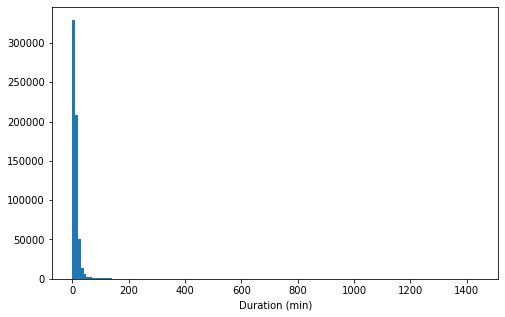

In [24]:
# start with a standard-scaled plot
binsize = 10
bins = np.arange(0, df['duration_min'].max()+binsize, binsize)

plt.figure(figsize=[8, 5])
plt.hist(data = df, x = 'duration_min', bins = bins)
plt.xlabel('Duration (min)')
plt.show()

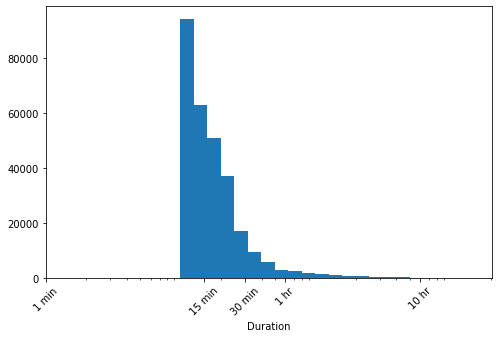

In [25]:
# there's a long tail in the distribution, so let's put it on a log scale instead
log_binsize = 0.1
bins = 10 ** np.arange(1, np.log10(df['duration_min'].max())+log_binsize, log_binsize)

plt.figure(figsize=[8, 5])
plt.hist(data = df, x = 'duration_min', bins = bins)
plt.xscale('log')
plt.xticks([1, 15, 30, 60, 600], ['1 min', '15 min', '30 min', '1 hr', '10 hr'])
plt.xlabel('Duration')
plt.xticks(rotation = 45)
plt.show();

The duration distribution is highly skewed to the right, both in linear and log scale. It is though more similar to a half of log normal distribution.

Now by looking at the box plot, we see that there are some extreme values at the heavy tail of the distributions.

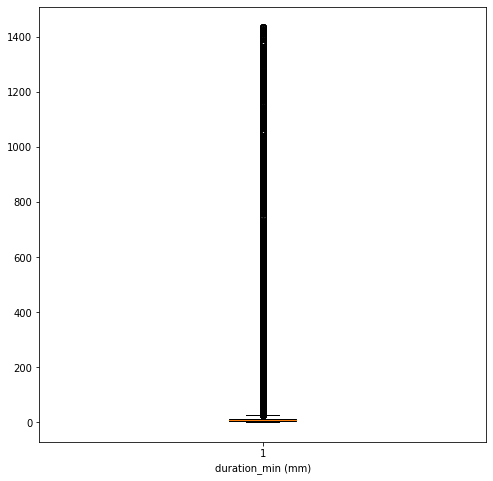

In [26]:
# Box plot of duration time
var = 'duration_min'
fig, ax = plt.subplots(nrows=1, ncols=1, figsize = [8,8])
plt.boxplot(df[var])
plt.xlabel('{} (mm)'.format(var))
plt.show()

At this point, I decide to ignore any duration time that is longer than 6 hours.

In [27]:
# This will drop 789 rows out of 520000
sum(df.duration_min>6*60),df.duration_min.shape[0]

(1238, 620000)

In [28]:
df = df[df.duration_min<=6*60];

Now the box plot shows a better shape, but still some extreme values are there. However, I choose to keep these values for further study. I will categorize the duration in three time slots short, medium, and long.

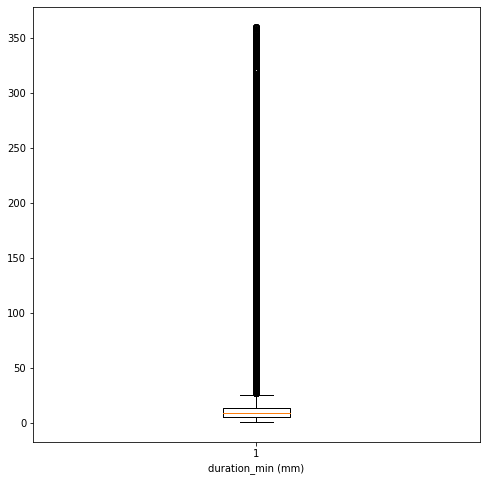

In [175]:
# Box plot of duration time
var = 'duration_min'
fig, ax = plt.subplots(nrows=1, ncols=1, figsize = [8,8])
plt.boxplot(df[var])
plt.xlabel('{} (mm)'.format(var))
plt.show()

And now for the position variables, I explore for out of range values.

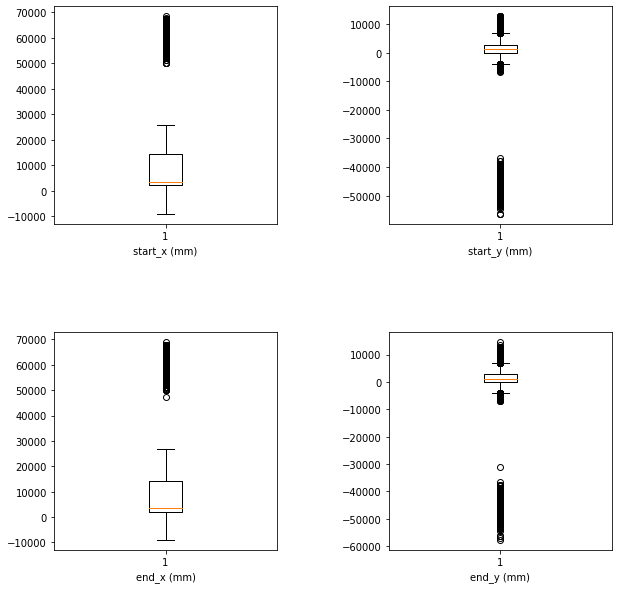

In [176]:
# Quantitative
fig, ax = plt.subplots(nrows=2, ncols=2, figsize = [10,10])
plt.subplots_adjust(wspace=0.5, hspace=0.5)
variables = ['start_x',
             'start_y',
             'end_x',
             'end_y']
for i in range(len(variables)):
    var = variables[i]
    plt.subplot(2,2,i+1)
    plt.boxplot(df[var])
    plt.xlabel('{} (mm)'.format(var))
plt.show()

And I keep only those x,y's that are in the range of 100 km from the refernce point.

In [31]:
# in x direction
lim = 100000;

left_bound_x  = df.start_x >= -lim;
print("Start left bound x removes ", sum(left_bound_x==False), " rows!")
df = df[left_bound_x]
right_bound_x = df.start_x <=  lim;
print("Start right bound x removes ", sum(right_bound_x==False), " rows!")
df = df[right_bound_x]
left_bound_y  = df.start_y >= -lim;
print("Start left bound y removes ", sum(left_bound_y==False), " rows!")
df = df[left_bound_y]
right_bound_y = df.start_y <=  lim;
print("Start right bound y removes ", sum(right_bound_y==False), " rows!")
df = df[right_bound_y]

left_bound_x  = df.end_x >= -lim;
print("End left bound x removes ", sum(left_bound_x==False), " rows!")
df = df[left_bound_x]
right_bound_x = df.end_x <=  lim;
print("End right bound x removes ", sum(right_bound_x==False), " rows!")
df = df[right_bound_x]
left_bound_y  = df.end_y >= -lim;
print("End left bound y removes ", sum(left_bound_y==False), " rows!")
df = df[left_bound_y]
right_bound_y = df.end_y <=  lim;
print("End right bound y removes ", sum(right_bound_y==False), " rows!")
df = df[right_bound_y]

Start left bound x removes  0  rows!
Start right bound x removes  6  rows!
Start left bound y removes  0  rows!
Start right bound y removes  0  rows!
End left bound x removes  0  rows!
End right bound x removes  2  rows!
End left bound y removes  0  rows!
End right bound y removes  0  rows!


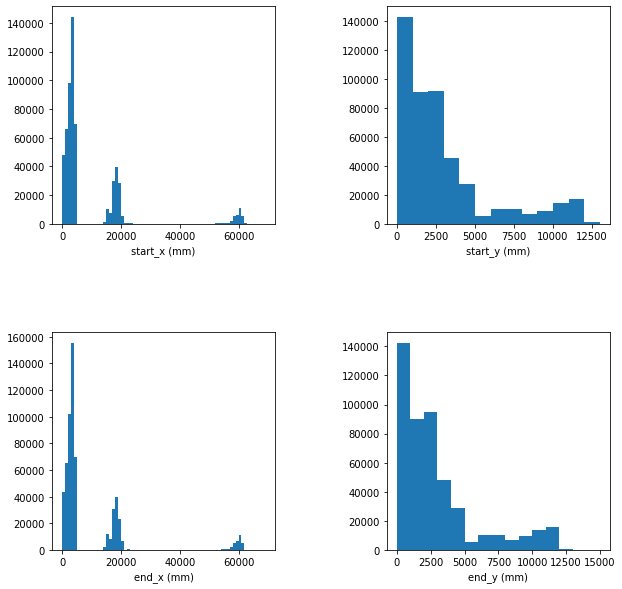

In [32]:
# start with a standard-scaled plot
fig, ax = plt.subplots(nrows=2, ncols=2, figsize = [10,10])
plt.subplots_adjust(wspace=0.5, hspace=0.5)

binsize = 1000
variables = ['start_x',
             'start_y',
             'end_x',
             'end_y']
for i in range(len(variables)):
    var = variables[i]
    bins = np.arange(0, df[var].max()+binsize, binsize)
    plt.subplot(2,2,i+1)
    plt.hist(data = df, x = var, bins = bins)
    plt.xlabel('{} (mm)'.format(var))
plt.show()

These plots show that there are three clusters of position that we can consider and label as position A, B and C. I will add a column to the df in the next step to consider this information.

### Qualtitative variables

I add a column that describes the location of the stations:<br>
- Region A for       x<10000
- Region B for 10000<x<40000
- Region B for 40000<x

In [33]:
# Regions based on x value intervals

# Start station
A = df.start_x<10000
C = df.start_x>40000
if not 'start_region' in df:
    df.insert(loc=6, column='start_region', value='B')
df.at[A,'start_region'] = 'A'
df.at[C,'start_region'] = 'C'

# End station
A = df.end_x<10000
C = df.end_x>40000
if not 'end_region' in df:
    df.insert(loc=10, column='end_region', value='B')
df.at[A,'end_region'] = 'A'
df.at[C,'end_region'] = 'C'

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 618754 entries, 0 to 619999
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   bike_id             618754 non-null  int64  
 1   time                618754 non-null  float64
 2   duration_min        618754 non-null  int64  
 3   hour                618754 non-null  int64  
 4   day                 618754 non-null  object 
 5   month               618754 non-null  int64  
 6   start_region        618754 non-null  object 
 7   year                618754 non-null  int64  
 8   start_x             618754 non-null  float64
 9   start_y             618754 non-null  float64
 10  end_region          618754 non-null  object 
 11  start_station_name  599995 non-null  object 
 12  end_x               618754 non-null  float64
 13  end_y               618754 non-null  float64
 14  end_station_name    599819 non-null  object 
 15  user_type           618754 non-nul

I add a column that describes the trips in terms of short or long.

In [35]:
# Short trips are those less than 30 min
# Medium trips are between 30 min and 2 hours
# More than 2 hours are long trips
flag_short = df.duration_min<30
flag_long = df.duration_min>120
if not 'trip' in df:
    df.insert(loc=2, column='trip', value='medium')
df.at[flag_short,'trip'] = 'short'
df.at[flag_long,'trip'] = 'long'

At this stage, I define category type for the ordinal variables to use their oder in the plots.

In [177]:
# convert trip, hour, day, month and year into ordered categorical types
ordinal_var_dict = {'trip':['short','medium','long'],
                    'hour': [int(c) for c in range(0,24)],
                    'day': ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'],
                    'month': [int(c) for c in range(1,13)],
                    'year': [int(c) for c in range(2017,2021)]}

for var in ordinal_var_dict:
    ordered_var = pd.api.types.CategoricalDtype(ordered = True, categories = ordinal_var_dict[var])
    df[var] = df[var].astype(ordered_var)

I plot all time ordinal variables.

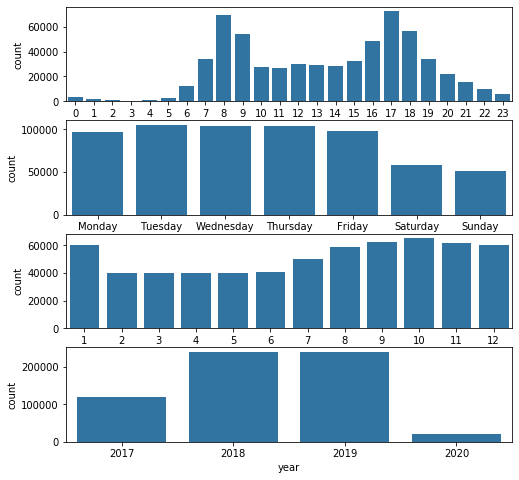

In [40]:
# let's plot all together to get an idea of each ordinal variable's distribution.

fig, ax = plt.subplots(nrows=4, figsize = [8,8])

default_color = sb.color_palette()[0]
sb.countplot(data = df, x = 'hour', color = default_color, ax = ax[0])
sb.countplot(data = df, x = 'day', color = default_color, ax = ax[1])
sb.countplot(data = df, x = 'month', color = default_color, ax = ax[2])
sb.countplot(data = df, x = 'year', color = default_color, ax = ax[3])

plt.show()

The first observation here is that the year entries are way different. This is due to the fact that we have half a year data for 2017, and only one month of 2020. So it is better to just look at 2018 and 2019.

In [178]:
# let's plot all together to get an idea of each ordinal variable's distribution.
df_ = df[df.year!=2017]
df_ = df_[df_.year!=2020]

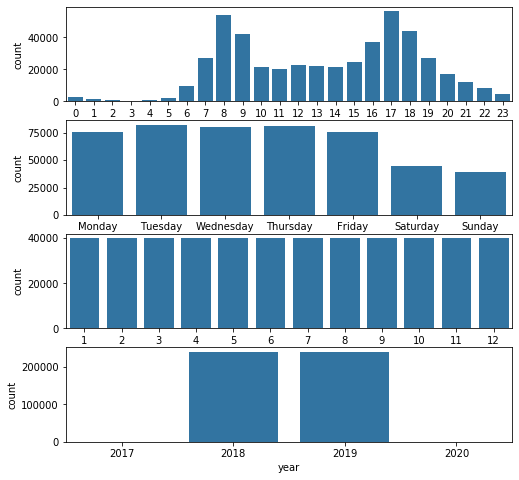

In [42]:
fig, ax = plt.subplots(nrows=4, figsize = [8,8])

default_color = sb.color_palette()[0]
sb.countplot(data = df_, x = 'hour', color = default_color, ax = ax[0])
sb.countplot(data = df_, x = 'day', color = default_color, ax = ax[1])
sb.countplot(data = df_, x = 'month', color = default_color, ax = ax[2])
sb.countplot(data = df_, x = 'year', color = default_color, ax = ax[3])

plt.show()

The results for 2018 and 2019 show that the monthly registered counts are almost identical. However, we see two trends for weekdays and day hours. Weekends and mondays show lower numbers.

I look now at the pie chart for three categorical variables: Trip time length (short,medium, and long), location (A,B,C) and the user type (casual customer or subscriber).

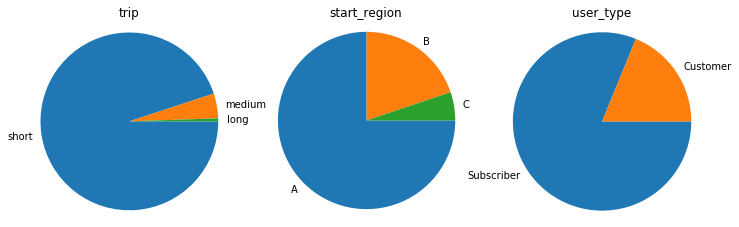

In [43]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize = [12,50])
plt.subplot(1,3,1);
sorted_counts = df['trip'].value_counts()
plt.pie(sorted_counts, labels = sorted_counts.index, startangle = 0,
        counterclock = False);
plt.title('trip')

plt.axis('square');

plt.subplot(1,3,2);
sorted_counts = df.start_region.value_counts()
plt.pie(sorted_counts, labels = sorted_counts.index, startangle = 0,
        counterclock = False);
plt.title("start_region")
plt.axis('square');

plt.subplot(1,3,3);
sorted_counts = df.user_type.value_counts()
plt.pie(sorted_counts, labels = sorted_counts.index, startangle = 0,
        counterclock = False);
plt.title("user_type")
plt.axis('square');

One interesting think to look at is the number of times a bike is used. This is specifacally important for the probability of maintanance and aging of the bikes, and the number of bikes to be injected to the system.

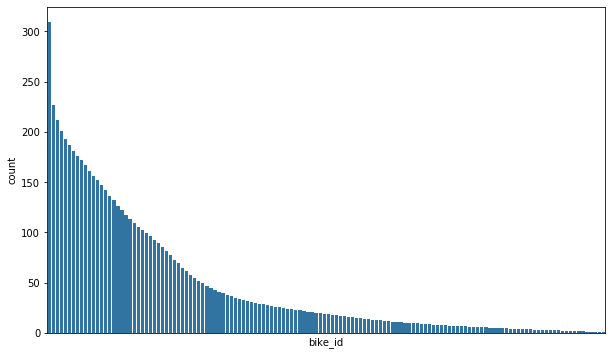

In [184]:
# To avoid the huge numebr of points, I slice the bike id's by steps of 100 bikes.
fig, ax = plt.subplots(nrows=1, ncols=1, figsize = [10,6])
base_color = sb.color_palette()[0]
cat_order = df.bike_id.value_counts()
index = range(0,cat_order.shape[0], 100)
g=sb.countplot(data=df, x='bike_id', color=base_color, order = cat_order.index[index])
g.set(xticks=[]);

This shows that almost one third of the bikes are heavily used, compared to the total number of bikes.

In [186]:
df_customer = df[df.user_type=='Customer']
df_subscriber = df[df.user_type=='Subscriber']

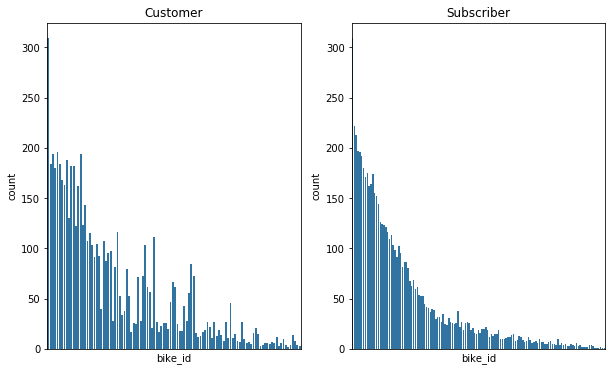

In [191]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize = [10,6])
base_color = sb.color_palette()[0]

plt.subplot(1,2,1)
cat_order = df_customer.bike_id.value_counts()
index = range(0,cat_order.shape[0], 100)
g=sb.countplot(data=df, x='bike_id', color=base_color, order = cat_order.index[index])
g.set(xticks=[], title='Customer');

plt.subplot(1,2,2)
cat_order = df_subscriber.bike_id.value_counts()
index = range(0,cat_order.shape[0], 100)
g=sb.countplot(data=df, x='bike_id', color=base_color, order = cat_order.index[index], label='Subscriber')
g.set(xticks=[], title='Subscriber');

When we separate the distribution by type of users, we see a narrower distribution for subscribers. This is expected, as there might be a number of regular riders that use the same bike for their trips.

The number of times the staions used as start or destination is more or less the same:

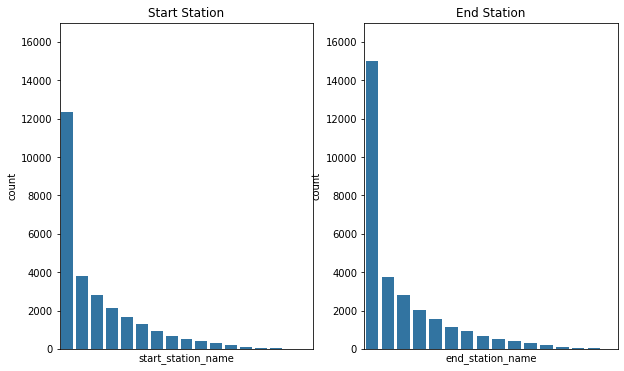

In [199]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize = [10,6])
base_color = sb.color_palette()[0]

plt.subplot(1,2,1)
cat_order = df.start_station_name.value_counts()
index = range(0,cat_order.shape[0], 30)
g=sb.countplot(data=df, x='start_station_name', color=base_color, order = cat_order.index[index])
g.set(xticks=[], title='Start Station', ylim=[0,17000]);

plt.subplot(1,2,2)
cat_order = df.end_station_name.value_counts()
index = range(0,cat_order.shape[0], 30)
g=sb.countplot(data=df, x='end_station_name', color=base_color, order = cat_order.index[index])
g.set(xticks=[], title='End Station', ylim=[0,17000]);


There are though stations that have more number of returns. There are also a number of stations that will recieve the same bikes left them:

In [47]:
sum(df.start_station_name == df.end_station_name)

16369

In [48]:
df.to_csv("df.csv", index=False)

### Checkpoint 

In [5]:
df = pd.read_csv("df.csv")

### Discuss the distribution(s) of your variable(s) of interest. Were there any unusual points? Did you need to perform any transformations?

- From the distribution of duration time, we could devide the entries to three groups: short trips, medium and long trips.<br>
- The positions are distributed in three east-west locations.<br>
- There is a visible trend in the weekdays and hours for the rate of bike sharing. Less used in the weekend, and more used in the mornings and evenings.<br>
- Almost one third of the bikes are heavily used, while others are used less frequently throughout the years.<br>

### Of the features you investigated, were there any unusual distributions? Did you perform any operations on the data to tidy, adjust, or change the form of the data? If so, why did you do this?

The duration and position variables had extreme values and heavy tails. While most of these values could be valid in real life ( for example, a trip that lasts ovar a day), I chose to remove them from the study. These numbers just make the scale harder to observe the trends that we are interested in.

## Bivariate Exploration

In this section, I investigate relationships between pairs of variables in the
data.

Earlier, I separated the positions of the staions based on the x coordinate clusters. Let us now look at the coordinates in 2D.

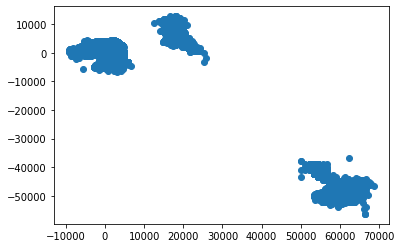

In [50]:
plt.scatter(data=df,x= 'start_x', y='start_y');

This obviously confirms the decision.

In [51]:
x_start = 'start_x'
y_start = 'start_y'
x_end = 'end_x'
y_end = 'end_y'

n_res = 50

min_x_start = min(df[x_start])
max_x_start = max(df[x_start])
min_y_start = min(df[y_start])
max_y_start = max(df[y_start])

min_x_end = min(df[x_end])
max_x_end = max(df[x_end])
min_y_end = min(df[y_end])
max_y_end = max(df[y_end])

min_x = min([min_x_start, min_x_end])
min_y = min([min_y_start, min_y_end])
max_x = max([max_x_start, max_x_end])
max_y = max([max_y_start, max_y_end])

step_start = min([max_x_start-min_x_start,max_y_start-min_y_start])/n_res
step_end   = min([max_x_end  -min_x_end  ,max_y_end  -min_y_end  ])/n_res
step = min([step_start,step_end])

bins_x = np.arange(min_x, max_x+step, step)
bins_y = np.arange(min_y, max_y+step, step)

Next we see that the number of times the stations are used for the start and end of the journey is higher for the cluster A which is closer to the cits center.

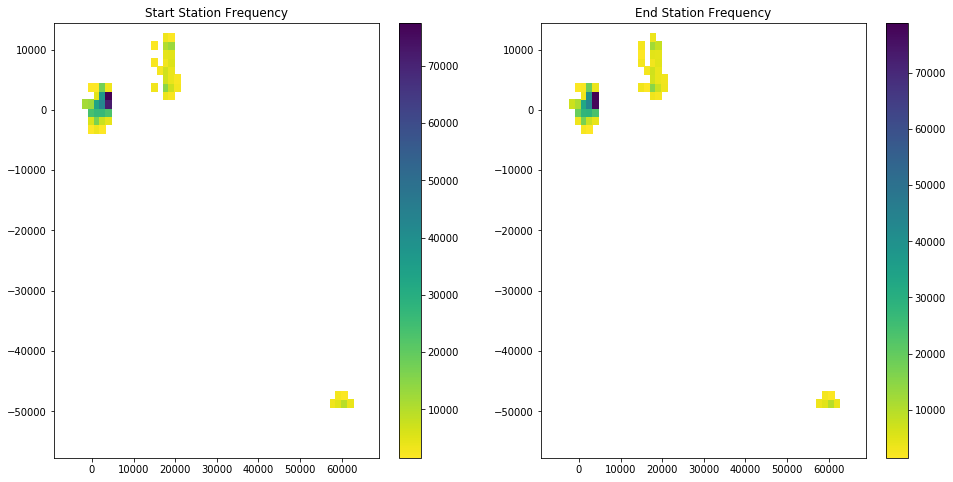

In [52]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize = [16,8], sharex=True,sharey=True)
plt.subplot(1,2,1)
plt.hist2d(data = df, x = x_start, y = y_start,
           bins = [bins_x, bins_y], 
           cmap = 'viridis_r', 
           cmin = step, 
           density=False)
plt.colorbar()
plt.title("Start Station Frequency")
plt.xlim([min_x, max_x])
plt.ylim([min_y, max_y])

plt.subplot(1,2,2)
plt.hist2d(data = df, x = x_end, y = y_end,
           bins = [bins_x, bins_y], 
           cmap = 'viridis_r', 
           cmin = step, 
           density=False)
plt.colorbar();
plt.title("End Station Frequency");
plt.xlim([min_x, max_x])
plt.ylim([min_y, max_y]);

In [205]:
# convert trip, hour, day, month and year into ordered categorical types
ordinal_var_dict = {'trip':['short','medium','long'],
                    'hour': [int(c) for c in range(0,24)],
                    'day': ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'],
                    'month': [int(c) for c in range(1,13)],
                    'year': [int(c) for c in range(2017,2021)]}

for var in ordinal_var_dict:
    ordered_var = pd.api.types.CategoricalDtype(ordered = True, categories = ordinal_var_dict[var])
    df[var] = df[var].astype(ordered_var)

In [207]:
numeric_vars = ['time','duration_min']

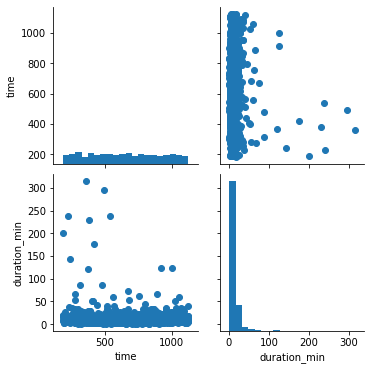

In [208]:
# plot matrix: sample 1000 shares so that plots are clearer and
# they render faster
random.seed(10)
df_samp = df.sample(1000)

g = sb.PairGrid(data = df_samp, vars = numeric_vars)
g = g.map_diag(plt.hist, bins = 20);
g.map_offdiag(plt.scatter);

for var in ordinal_var_dict:
    ordered_var = pd.api.types.CategoricalDtype(ordered = True, categories = ordinal_var_dict[var])
    df_samp[var] = df_samp[var].astype(ordered_var)

The above plot shows that the timestamp points are uniformly distributed that shows there has been constantly an entry over time. There is a constant level for the trip duration. 

<Figure size 432x288 with 0 Axes>

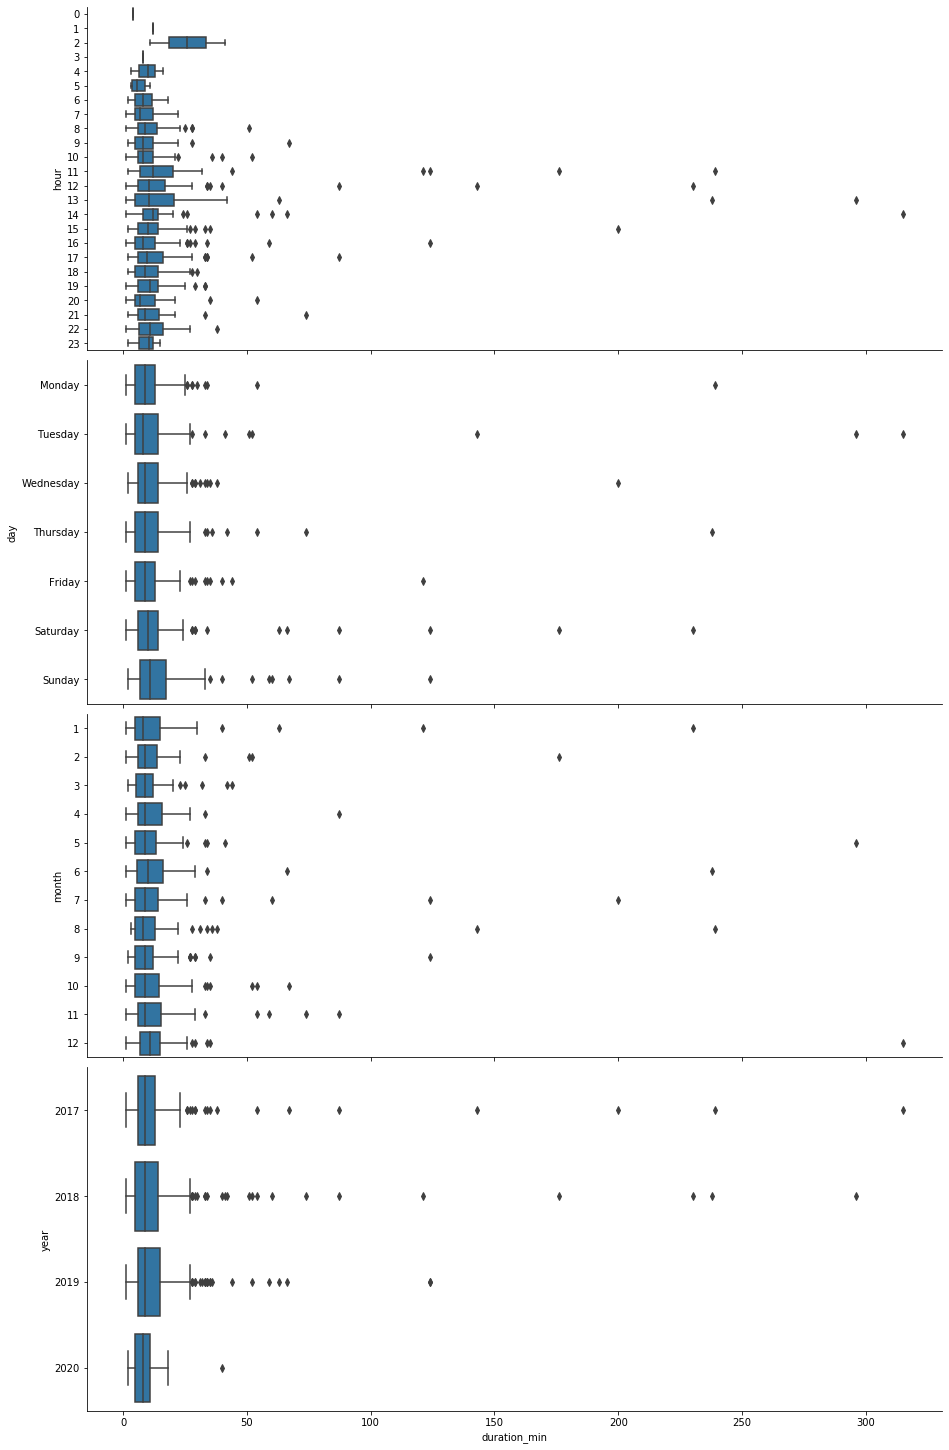

In [213]:
# plot matrix of numeric features against categorical features.
# can use a larger sample since there are fewer plots and they're simpler in nature.
def boxgrid(x, y, **kwargs):
    """ Quick hack for creating box plots with seaborn's PairGrid. """
    default_color = sb.color_palette()[0];
    sb.boxplot(x, y, color = default_color);

plt.figure();
g = sb.PairGrid(data = df_samp, x_vars = 'duration_min', y_vars = categoric_vars,
                height = 5, aspect = 2.5);
g.map(boxgrid)
plt.show();

Here we observe that the long values make the scale hard to pbserve the pattern. I filter out the long times:

<Figure size 432x288 with 0 Axes>

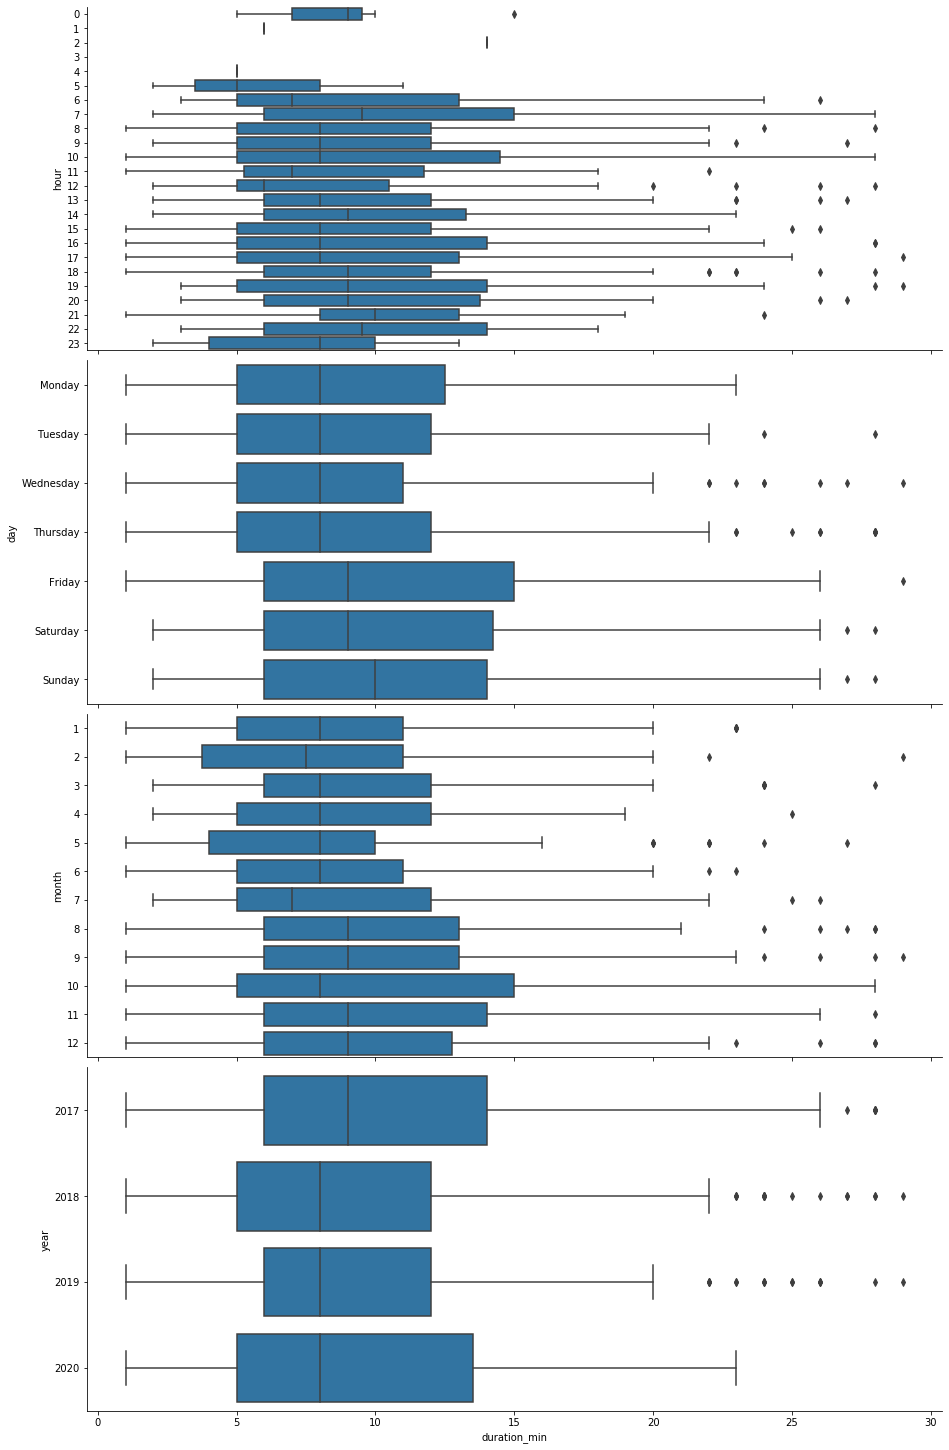

In [60]:
def boxgrid(x, y, **kwargs):
    """ Quick hack for creating box plots with seaborn's PairGrid. """
    default_color = sb.color_palette()[0]
    sb.boxplot(x, y, color = default_color)

df_samp = df_samp[df_samp.trip=='short']

plt.figure()
g = sb.PairGrid(data = df_samp, x_vars = 'duration_min', y_vars = categoric_vars,
                height = 5, aspect = 2.5)
g.map(boxgrid)
plt.show();

Now here it is easier to see the statitics of duration versus the year, month, weekday and hour.<br>
The trips per day are shown below. It is interesting to see that the length of the trips increases at the weekend for medium and long trips and drops significantly for the short trips:

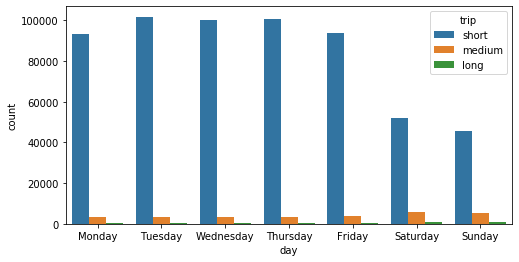

In [215]:
plt.figure(figsize = [8, 4])
sb.countplot(data = df, x = 'day', hue = 'trip');

Other interesting observation is that the short trips are more centered at the morning and evening times, while the medium and long trips are more at the middle of the day.

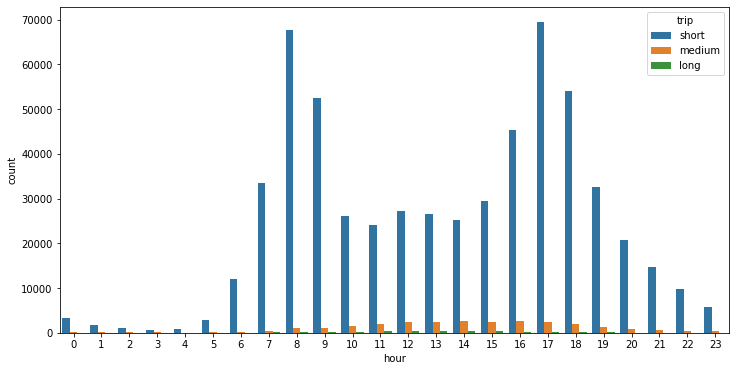

In [217]:
plt.figure(figsize = [12,6])
sb.countplot(data = df, x = 'hour', hue = 'trip');

It is very interesting to see that the subsribed people use the system more on the working days, while the casual users tend to use the bikes more at the weekends.

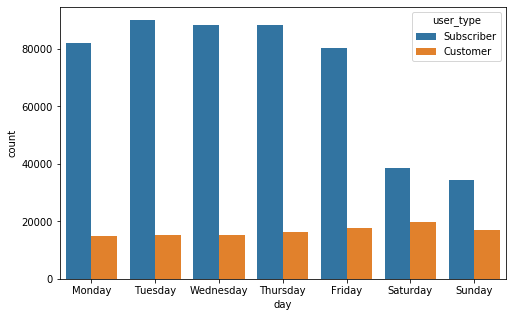

In [219]:
plt.figure(figsize = [8,5])
sb.countplot(data = df, x = 'day', hue = 'user_type');

Other observation is that the subscribers use the bikes to go to work and come back, while the casual customers use them more leveled thorugh out the day.

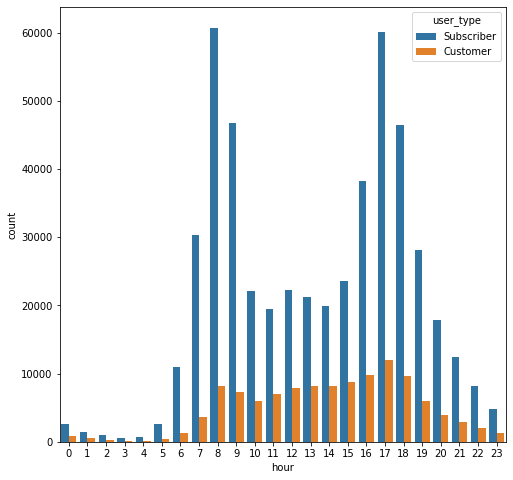

In [64]:
plt.figure(figsize = [8, 8])
sb.countplot(data = df, x = 'hour', hue = 'user_type');

Another interesting observation is the trend between 2018 and 2019. The subscribers are declining in number and the customers are increasing over the two years.

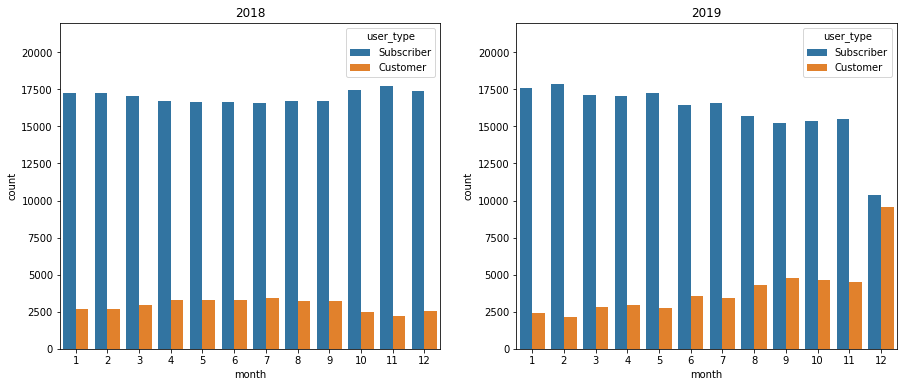

In [65]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize = [15,6])
plt.subplots_adjust(wspace=0.2)

plt.subplot(1,2,1)
sb.countplot(data = df[df.year==2018], x = 'month', hue = 'user_type');
plt.ylim([0,22000])
plt.title('2018');

plt.subplot(1,2,2)
sb.countplot(data = df[df.year==2019], x = 'month', hue = 'user_type');
plt.ylim([0,22000])
plt.title('2019');

Finally, the region B is declining in the two-year window.

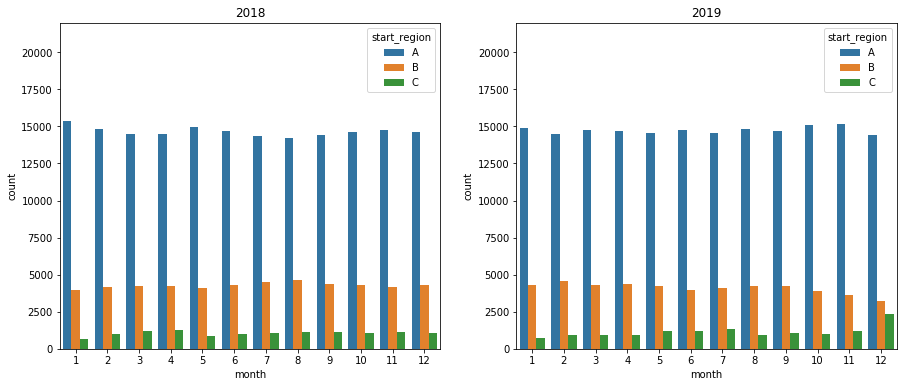

In [66]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize = [15,6])
plt.subplots_adjust(wspace=0.2)
ind = df.start_region.value_counts().index;

plt.subplot(1,2,1)
sb.countplot(data = df[df.year==2018], x = 'month', hue = 'start_region', hue_order=ind);
plt.ylim([0,22000])
plt.title('2018');

plt.subplot(1,2,2)
sb.countplot(data = df[df.year==2019], x = 'month', hue = 'start_region', hue_order=ind);
plt.ylim([0,22000])
plt.title('2019');

Here, I plot the number of hour entries versus number of weekday entries.

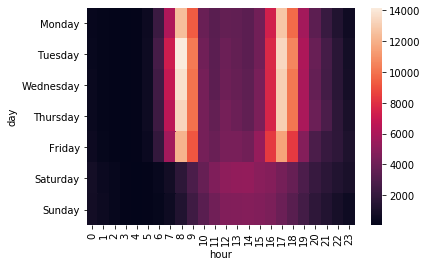

In [220]:
v1,v2 = 'hour', 'day'

ct_counts = df.groupby([v1,v2]).size()

ct_counts = ct_counts.reset_index(name='count')

ct_counts = ct_counts.pivot(index = v2, columns = v1, values = 'count')

sb.heatmap(ct_counts);

The plot shows that the working days in the start and end of the day are the most used times.

The following plot shows how the weekdays usage change over months:

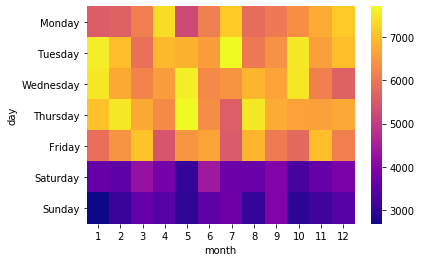

In [221]:
v1,v2 = 'month', 'day'
df_ = df[df.year!=2017]
df_ = df_[df_.year!=2020]

ct_counts = df_.groupby([v1,v2]).size()

ct_counts = ct_counts.reset_index(name='count')

ct_counts = ct_counts.pivot(index = v2, columns = v1, values = 'count')

sb.heatmap(ct_counts,cmap = 'plasma');

Looking at the relations between weekdays and the trip lenght, we see that most of the trips have been short and on the weekdays.

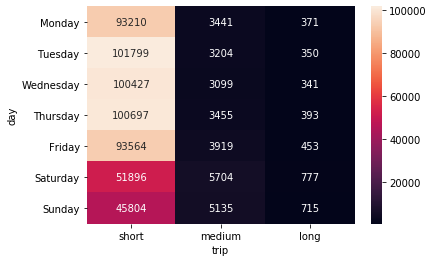

In [222]:
v1,v2 = 'trip', 'day'

ct_counts = df.groupby([v1,v2]).size()

ct_counts = ct_counts.reset_index(name='count')

ct_counts = ct_counts.pivot(index = v2, columns = v1, values = 'count')

sb.heatmap(ct_counts,annot = True, fmt = 'd');

Finally the trip lenght separated by region: Region A shows the most short trips.

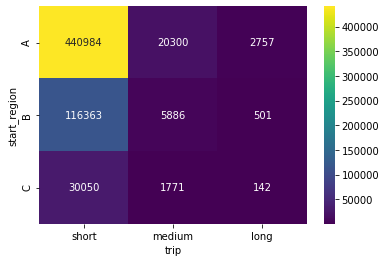

In [95]:
v1,v2 = 'trip', 'start_region'

ct_counts = df.groupby([v1,v2]).size()

ct_counts = ct_counts.reset_index(name='count')

ct_counts = ct_counts.pivot(index = v2, columns = v1, values = 'count')

sb.heatmap(ct_counts, cmap='viridis',annot = True, fmt = 'd');

We examine the moving average here to observe the variations of duration time per timestap.

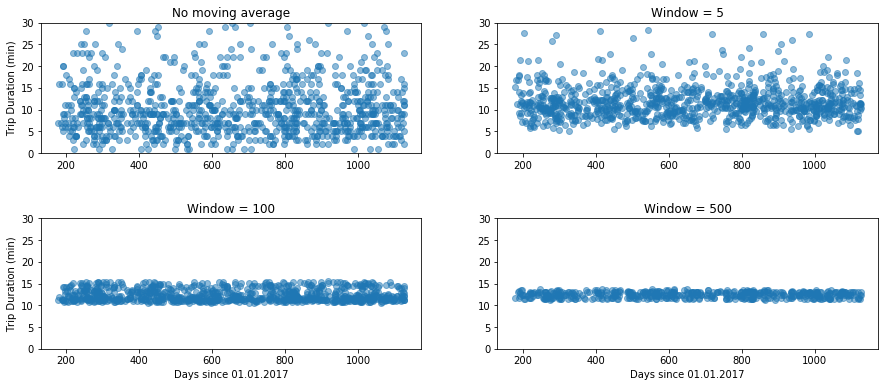

In [223]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize = [15,6])
plt.subplots_adjust(wspace=0.2, hspace=0.5)
lim = [0,30]
n_res = 1000
df_ = df.sample(n_res)

plt.subplot(2,2,1)
plt.scatter(df_.time, df_['duration_min'], alpha=0.5);
plt.ylim(lim)
plt.title('No moving average')
plt.ylabel('Trip Duration (min)')

plt.subplot(2,2,2)
plt.scatter(df_.time, df_['duration_min'].rolling(window=7).mean(), alpha=0.5);
plt.ylim(lim)
plt.title('Window = 5')

plt.subplot(2,2,3)
plt.scatter(df_.time, df_['duration_min'].rolling(window=120).mean(), alpha=0.5);
plt.ylim(lim)
plt.title('Window = 100')
plt.ylabel('Trip Duration (min)')
plt.xlabel('Days since 01.01.2017');

plt.subplot(2,2,4)
plt.scatter(df_.time, df_['duration_min'].rolling(window=500).mean(), alpha=0.5);
plt.ylim(lim)
plt.title('Window = 500');
plt.xlabel('Days since 01.01.2017');

This shows that the average duration is between 10 and 15 minutes. The values however vary heugly over this average that can be observed in the following plot:

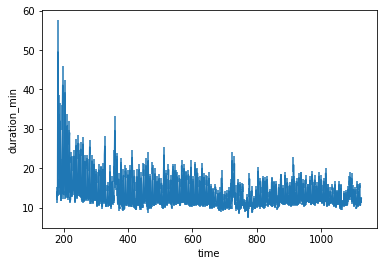

In [224]:
sb.reset_orig()
dfp, v1,v2,nc,log_binsize = df,'duration_min','time', 3, 1

#bin_edges = 10 ** np.arange(1.7, np.log10(dfp[v2].max())+log_binsize, log_binsize)
bin_edges= np.arange(0, dfp[v2].max()+log_binsize, log_binsize)

# set bin edges, compute centers
xbin_centers = (bin_edges + log_binsize/2)[:-1]

# compute statistics in each bin
data_xbins = pd.cut(df[v2], bin_edges, right = False, include_lowest = True)
y_means = df[v1].groupby(data_xbins).mean()
y_sems = df[v1].groupby(data_xbins).sem()

# plot the summarized data
plt.errorbar(x = xbin_centers, y = y_means, yerr = y_sems)
plt.xlabel(v2)
plt.ylabel(v1);

Finally, we observe the duration time historgams separated by user type:

/home/ma/anaconda3/envs/dal/lib/python3.8/site-packages/seaborn/axisgrid.py:243: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


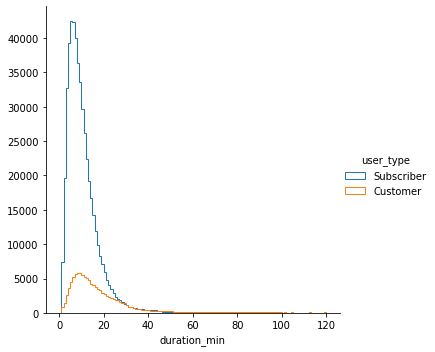

In [174]:
sb.reset_orig()
ind = df.trip!='long'
dfp, v1,v2,nc, binsize = df[ind],'user_type','duration_min', 3, 1

#bin_edges = 10 ** np.arange(1.7, np.log10(dfp[v2].max())+log_binsize, log_binsize)
bin_edges= np.arange(0, dfp[v2].max()+ binsize, binsize)

g = sb.FacetGrid(data = df, hue = v1, size = 5)
g.map(plt.hist, v2, bins = bin_edges, histtype = 'step')
g.add_legend()

### Talk about some of the relationships you observed in this part of the investigation. How did the feature(s) of interest vary with other features in the dataset?
We have looked at the usage time over the weekdays and daily hours. The trends show that short trips are mostly used for regular trips in the morning and evening in the working days.

The other observation was the average of the trips that is between 10 and 15 minutes.<br>

Regular users use the system mostly at the working days and the casual customers at the weekend.

### Did you observe any interesting relationships between the other features (not the main feature(s) of interest)?

The trend of user suscription decline and the causal usage increase over 2018 and 2019 was interesting.


## Multivariate Exploration

> Create plots of three or more variables to investigate your data even
further. Make sure that your investigations are justified, and follow from
your work in the previous sections.

In [7]:
df.columns

Index(['duration_sec', 'start_station_id', 'start_station_name',
       'start_station_latitude', 'start_station_longitude', 'end_station_id',
       'end_station_name', 'end_station_latitude', 'end_station_longitude',
       'bike_id', 'user_type', 'bike_share_for_all_trip',
       'rental_access_method', 'dist_start_to_end', 'hour', 'day', 'month',
       'year', 'duration_qualitative'],
      dtype='object')

For the long trip, there is a prononced decline over the years. This moobservable in the subscribed users.

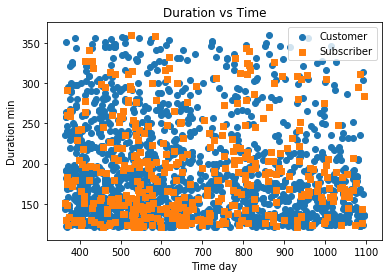

In [251]:
cat_markers = [['Customer', 'o'],
               ['Subscriber', 's']]

df_ = df[df.trip=='long']
df_ = df_[df_.year!=2017]
df_ = df_[df_.year!=2020]
random.seed(10)

for cat, marker in cat_markers:
    df_cat = df_[df_['user_type'] == cat]
    plt.scatter(data = df_cat, x = 'time', y = 'duration_min', marker = marker);
plt.legend(['Customer','Subscriber']);
plt.title('Duration vs Time');
plt.xlabel('Time day');
plt.ylabel('Duration min');

/home/ma/anaconda3/envs/dal/lib/python3.8/site-packages/seaborn/axisgrid.py:243: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


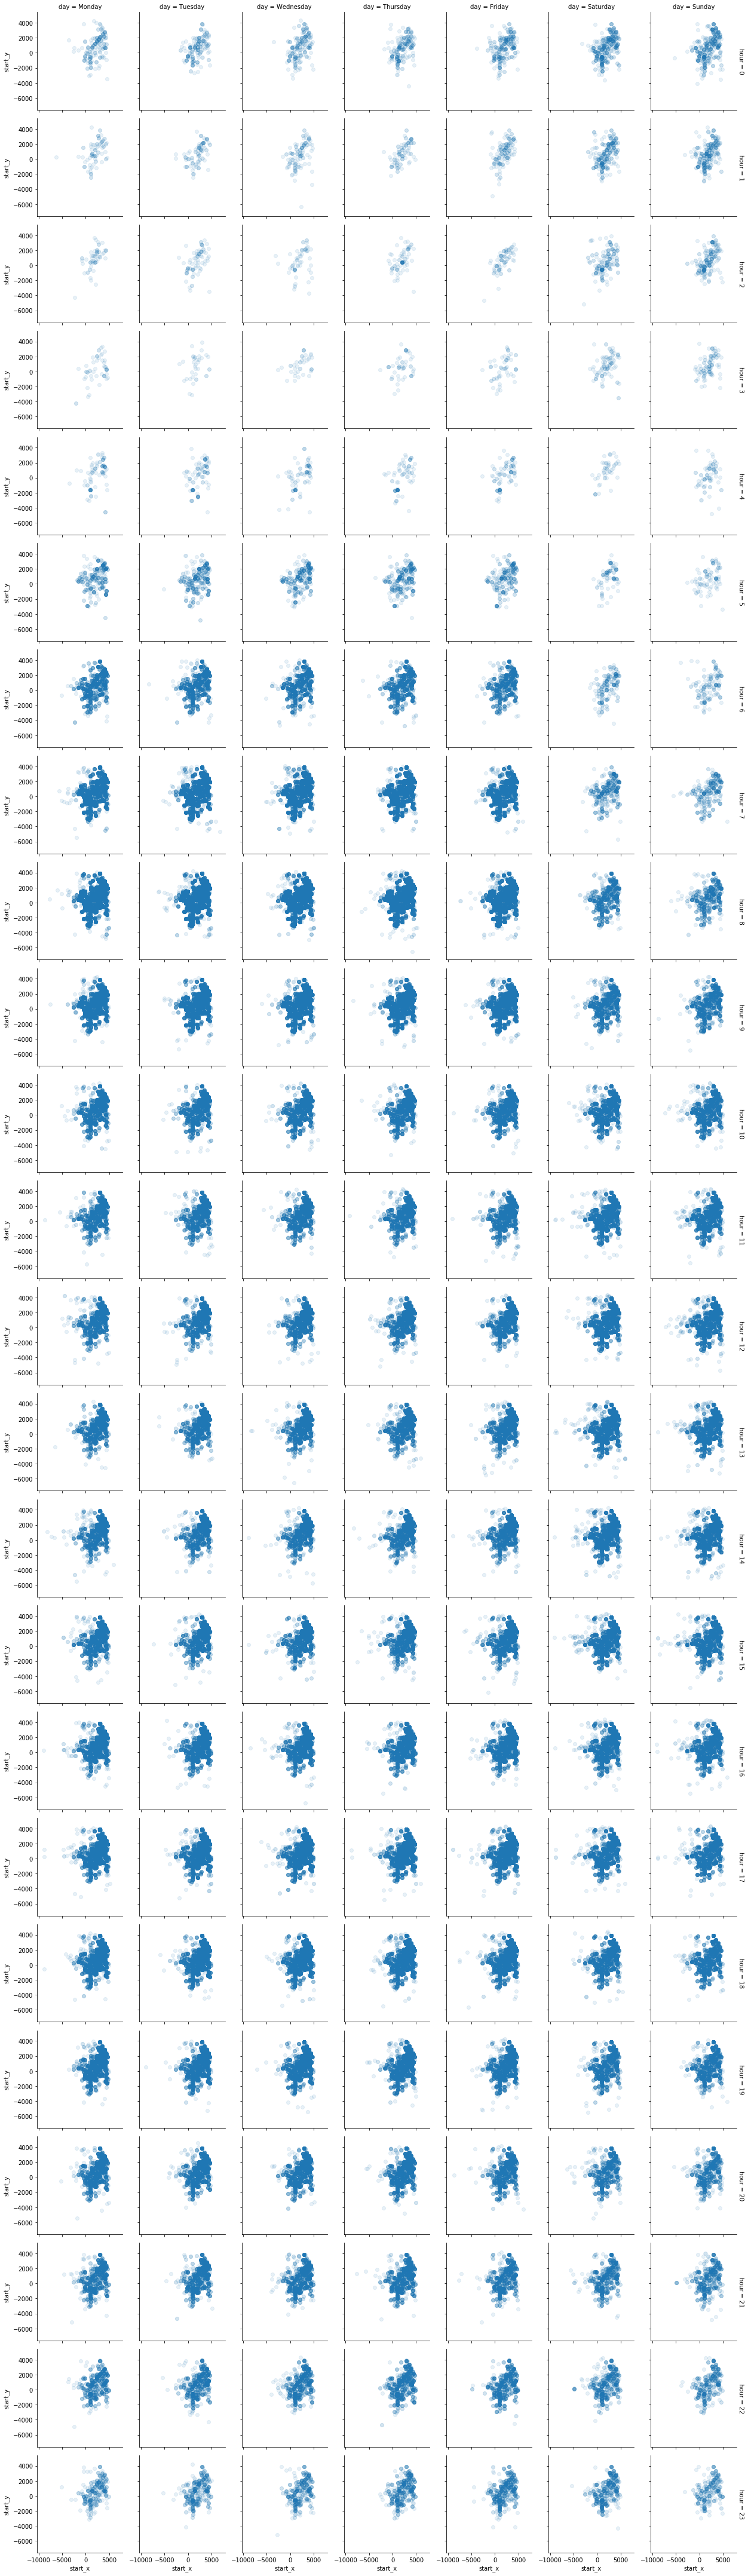

In [253]:
vc1,vc2,vn1,vn2 = 'hour', 'day', 'start_x', 'start_y'
g = sb.FacetGrid(data = df[df.start_region=='A'], col = vc2, row = vc1, size = 2.5, margin_titles = True)
g.map(sb.regplot, vn1, vn2, fit_reg = False, scatter_kws = {'alpha' : 1/10}, x_jitter=10, y_jitter=10);

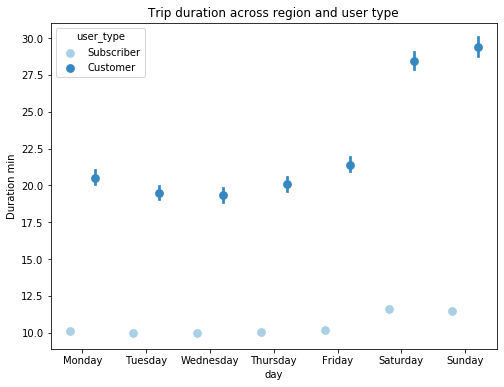

In [262]:
fig = plt.figure(figsize = [8,6])
ax = sb.pointplot(data = df, x = 'day', y = 'duration_min', hue = 'user_type',
           palette = 'Blues', linestyles = '', dodge = 0.4)
plt.title('Trip duration across region and user type')
plt.ylabel('Duration min')
#plt.yscale('log')
#plt.yticks([2e3, 4e3, 6e3, 1e4], ['2k', '4k', '6k', '10k'])
ax.set_yticklabels([],minor = True)
plt.show();

A dodged point plot for bike sharing duration in min shows the clear influence of weekday and user type on the trip duration average. Additionaly, there is a level difference in the duration time for customers which is about 10 mins.

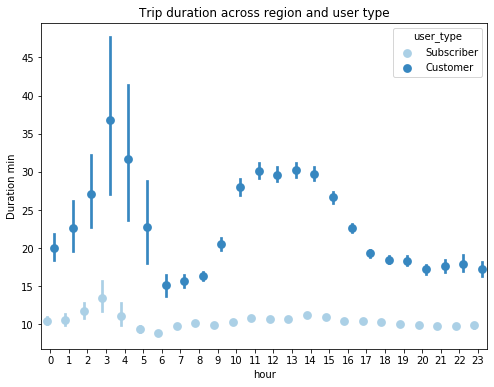

In [263]:
fig = plt.figure(figsize = [8,6])
ax = sb.pointplot(data = df, x = 'hour', y = 'duration_min', hue = 'user_type',
           palette = 'Blues', linestyles = '', dodge = 0.4)
plt.title('Trip duration across region and user type')
plt.ylabel('Duration min')
#plt.yscale('log')
#plt.yticks([2e3, 4e3, 6e3, 1e4], ['2k', '4k', '6k', '10k'])
ax.set_yticklabels([],minor = True)
plt.show();

The trend is clear in the plot over hours. The error bars in the early morning ours is due to the lower number of points there.

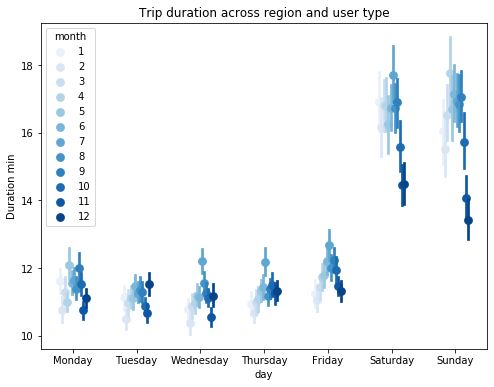

In [265]:
df_ = df[df.year!=2017]
df_ = df_[df_.year!=2020]

fig = plt.figure(figsize = [8,6])
ax = sb.pointplot(data = df_, x = 'day', y = 'duration_min', hue = 'month',
           palette = 'Blues', linestyles = '', dodge = 0.4)
plt.title('Trip duration across region and user type')
plt.ylabel('Duration min')
#plt.yscale('log')
#plt.yticks([2e3, 4e3, 6e3, 1e4], ['2k', '4k', '6k', '10k'])
ax.set_yticklabels([],minor = True)
plt.show();

And finally, the interesting trend observed for the months on the weekend show an increase and decreas. End of the year is declining dramatically in duration time.

### Talk about some of the relationships you observed in this part of the investigation. Were there features that strengthened each other in terms of looking at your feature(s) of interest?
The trends observed previously are more visible and clear in the multiple variable plots. For example, there is a separation in average of the duration time for user type.

### Were there any interesting or surprising interactions between features?
The month and weekday plot shows a suprising trend that cannot be seen in two variable plot easily. The weekend trends for end of the year is very vsisibl.